In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns


The goal of this project is to built Credit Scorecard based on the logistic regression, and compare its performance with other models.

# 1. Introduction
-----
A credit scorecard is a mathmeatical model that uses features to determine a threshold of risk tolerance. It provides a clear and intuitive way of presenting model results. For this reason, credit managers can quickly identify the credit risk of customers. 

There is a example. 

| Variable    | Level | ScoareCard Points
| ----------- | -----------        |-----------|
| Income      |  x<$15,000         |  100      |
| Income      | $15,000≤x<$35,000  |  120      |
| Income      | $35,000≤x<$50,000  |  140      |
| Income      |  $50,000≤x         |  160      |
| Ownership   |   Rent             |  100      |
| Ownership   |   Own              |  200      |
| Eduction    |  Higher education  |  210      |
| Eduction    |  Lower eduction    |  180      |


 <strong> Credit Approval Threshold >= 500 </strong>  
<u>Client 1</u>  
Income = $20,000 &emsp; &emsp;&emsp;&emsp;&emsp; 120 score  
Ownership = own  &emsp; &emsp; &emsp;&emsp;&emsp;&ensp;200 score  
<u>Eduction = Higher education  &ensp;&nbsp;210 score </u>  
Total  &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp;&emsp;&emsp;&emsp;  530 score  
 <strong> Loan approved</strong>

 Since the score of Client 1 is over 500, we can approve the loan. 


# 2. Data
-------
The dataset comes from [Credit Card Approval Prediction](https://www.kaggle.com/rikdifos/credit-card-approval-prediction) 

There are two tables. The First table:<strong>application_record</strong>
| Feature name      | Explanation | Remarks
| -------------- | -----------|-----------|
|ID	          | Client number	||
|CODE_GENDER	    |Gender	||
|FLAG_OWN_CAR       |	Is there a car	
|FLAG_OWN_REALTY     |	Is there a property	
|CNT_CHILDREN |	Number of children	
|AMT_INCOME_TOTAL |	Annual income	
|NAME_INCOME_TYPE|	Income category	
|NAME_EDUCATION_TYPE|	Education level	
|NAME_FAMILY_STATUS|	Marital status	
|NAME_HOUSING_TYPE	|Way of living	
|DAYS_BIRTH|	Birthda	|Count backwards from current day (0) <br>-1 means yesterday<br/>
|DAYS_EMPLOYED|	Start date of employment|Count backwards from current day(0)  <br>If positive, it means the person currently unemployed.<br/>
|FLAG_MOBIL|	Is there a mobile phone	
|FLAG_WORK_PHONE|	Is there a work phone	
|FLAG_PHONE|	Is there a phone	
|FLAG_EMAIL	|Is there an email	
|OCCUPATION_TYPE|	Occupation	
  
Second table: <strong>credit_record</strong>  
| Feature name      | Explanation | Remarks
| -------------- | -----------|-----------|
|ID	Client number	
|MONTHS_BALANCE	|Record month|The month of the extracted data is the starting point, backwards<br/> <br>0 is the current month<br/> <br>-1 is the previous month, and so on<br/>
|STATUS|	Status	|0: 1-29 days past due<br/> <br>1: 30-59 days past due<br/>  <br>2: 60-89 days overdue<br/>  <br>3: 90-119 days overdue <br/> <br>4: 120-149 days overdue<br/> <br>5: Overdue or bad debts, write-offs for more than 150 days <br/> <br>C: paid off that month</br> <br>X: No loan for the month<br/>

Based on these two, the definition of 'good' or 'bad' is not given. For this reaon, a technique, <strong>vintage analysis </strong>, can help us to constrcut lable 

# 3. Vintage analysis
In credit risk, it is a popular method for managing credit risk. The term 'Vintage' refers to the month or quarter in which account was opened (loan was granted). In simple words, the vintage analysis measures the performance of a portfolio in different periods of time after the loan (or credit card) was granted. Performance can be measured in the form of cumulative charge-off rate, proportion of customers 30/60/90 days past due (DPD), utilization ratio, average balance etc.

*Reference: [CREDIT RISK: VINTAGE ANALYSIS](https://www.listendata.com/2019/09/credit-risk-vintage-analysis.html)*

The purpose of using vintage anlysis:  
* Identify if an applicant is 'good' or 'bad' client  
* Determine the optimal period of obervation window in development of scorecard


## STEP 1: Loanding the data 

In [12]:
#load data
credit = pd.read_csv('./data/credit_record.csv', low_memory=True)
credit.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


## STEP 1: Compute MOB and Window 
MOB is the number of months that have completed since the loan origination Date. 

$\text{MOB} = \text{Record Month} - \text{Start Month}$

Observation window is the number of months starting from start month 

$\text{Window} = \text{End Month} - \text{Start Month}$

In [13]:
# calculate the start month of each loan
start_month = credit.groupby("ID")["MONTHS_BALANCE"].min()
credit = credit.merge(start_month,left_on ="ID",right_on = "ID",suffixes =("", "_y"))
credit.rename(columns=({"MONTHS_BALANCE_y":"start_month"}),inplace = True)

# calculate the end month of each loan
end_month = credit.groupby("ID")["MONTHS_BALANCE"].max()
credit = credit.merge(end_month,left_on ="ID",right_on = "ID",suffixes =("", "_y"))
credit.rename(columns=({"MONTHS_BALANCE_y":"end_month"}),inplace = True)

# calculate the window
credit ["window"] = credit["end_month"] - credit["start_month"]

# calculate the MOB
credit['month_on_book'] = credit['MONTHS_BALANCE'] - credit['start_month'] 
credit.sort_values(by = ['ID','month_on_book'], inplace = True)

# total number of accont for each month
denominator = pd.DataFrame({"start_month":start_month.value_counts().sort_index().index,"count_all":start_month.value_counts().sort_index().values})

In [8]:
credit 

,ID,MONTHS_BALANCE,STATUS,start_month,end_month,window,month_on_book
3,5001711,-3,0,-3,0,3,0
2,5001711,-2,0,-3,0,3,1
1,5001711,-1,0,-3,0,3,2
0,5001711,0,X,-3,0,3,3
22,5001712,-18,0,-18,0,18,0
...,...,...,...,...,...,...,...
1048549,5150487,-4,C,-29,0,29,25
1048548,5150487,-3,C,-29,0,29,26
1048547,5150487,-2,C,-29,0,29,27
1048546,5150487,-1,C,-29,0,29,28


## Step 2: Deal with Outlier 

There are some data with mistakes.Take "ID 5024071" as an example. when it just opened account at first month, the stuatus was 5, which means "Overdue or bad debts, write-offs for more than 150 days". In this situation, we consider such data is input data error. So we should remove such data. 

In [432]:
pd.DataFrame(credit[credit["ID"]==5024071]["STATUS"].values,index=credit[credit["ID"]==5024071]["month_on_book"]).T

month_on_book,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,5,0,0,C,C,C,C,C,C,C,...,C,C,C,C,C,C,C,C,C,C


In [14]:
# checking data error
check_error = credit[credit["month_on_book"] <=5][["ID","STATUS","month_on_book"]]

# changing x and C to 0, which means non-default
check_error['STATUS'] = np.where((check_error['STATUS'] == 'X') |(check_error['STATUS'] == 'C'),0, check_error['STATUS'])

# if STATUS > MOB, the data is error
error_ID = set(check_error[check_error['STATUS'].astype("int") > check_error['month_on_book']]["ID"])

# delet rows with error
credit = credit[~credit["ID"].isin(error_ID)]

## Step 3: Calculate the cumulative % of bad customers based on different past due days

In [15]:
# vintage table 
vintage = credit.groupby(['start_month','month_on_book']).agg({'ID': ['count']}).reset_index()
vintage.columns = ['start_month','month_on_book','count'] 
vintage = vintage[['start_month','month_on_book']]
vintage = vintage.merge(denominator, on= "start_month")
vintage

,start_month,month_on_book,count_all
0,-60,0,415
1,-60,1,415
2,-60,2,415
3,-60,3,415
4,-60,4,415
...,...,...,...
1886,-2,1,771
1887,-2,2,771
1888,-1,0,686
1889,-1,1,686


In [16]:
# identify default 
pd.options.mode.chained_assignment = None 
credit['def30'] = np.where((credit['STATUS'] == '1') |(credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 1, 0)

credit['def60'] = np.where((credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 1, 0)

credit['def90'] = np.where((credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 1, 0)

credit['def120'] = np.where((credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 1, 0)

credit['def150'] = np.where((credit['STATUS'] == '5'), 1, 0)

In [17]:
# Avoid The Double Counting - each ID just count once when the default happend
for i in [30,60,90,120,150]:
    def_index = "def{}".format(i)
    def_1st = credit[credit[def_index] == 1].groupby("ID").agg({"month_on_book":["min"]}).reset_index()
    def_1st.columns = ["ID","month_on_book"]
    def_1st["def{}_dedup".format(i)] = 1
    credit = credit.merge(def_1st,on=["ID","month_on_book"],how="left")
    credit  = credit.fillna(0)
    # merge with vitage
    vintage = vintage.merge(credit.groupby(["start_month","month_on_book"]).agg({"def{}_dedup".format(i):sum}).reset_index(),on=["start_month","month_on_book"])
    vintage.rename(columns=({"def{}_dedup".format(i):"def{}_num".format(i)}),inplace = True)
    # count the cumulative number of default.
    vintage = vintage.merge(vintage.groupby("start_month").agg({"def{}_num".format(i):"cumsum"}), left_index=True, right_index=True,suffixes=("","_cum"))
    vintage["def{}_ratio_cum".format(i)] = vintage["def{}_num_cum".format(i)] / vintage["count_all"]

## Step 4: creae vintage table

In [18]:
# Viewing the vintage table
vintage_values = "def60_ratio_cum"	
vintage.pivot(index = "start_month", columns="month_on_book",values=vintage_values)

month_on_book,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
start_month,,,,,,,,,,,,,,,,,,,,,
-60,0.0,0.0,0.000000,0.000000,0.000000,0.002410,0.002410,0.007229,0.007229,0.009639,...,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.031325,0.031325,0.031325
-59,0.0,0.0,0.000000,0.002463,0.002463,0.002463,0.004926,0.004926,0.004926,0.009852,...,0.027094,0.027094,0.027094,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,NaN
-58,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.004545,0.006818,0.006818,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN
-57,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.005000,0.005000,0.005000,...,0.022500,0.022500,0.022500,0.022500,0.022500,0.022500,0.022500,NaN,NaN,NaN
-56,0.0,0.0,0.004255,0.004255,0.008511,0.010638,0.010638,0.017021,0.017021,0.021277,...,0.036170,0.036170,0.036170,0.036170,0.038298,0.038298,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-4,0.0,0.0,0.000000,0.001144,0.001144,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-3,0.0,0.0,0.001088,0.001088,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2,0.0,0.0,0.001297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


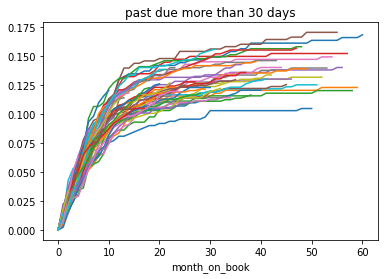

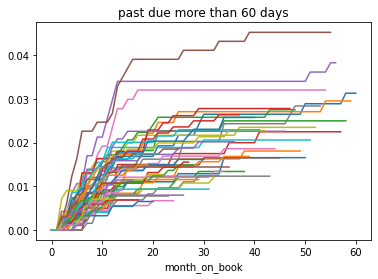

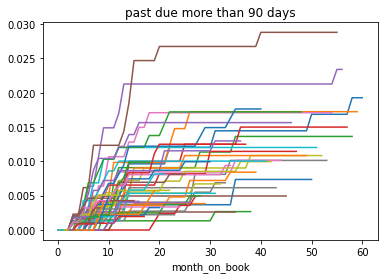

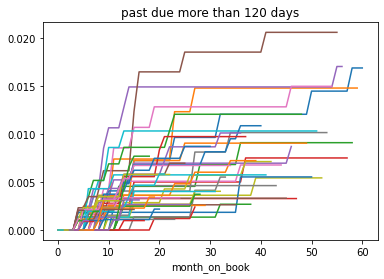

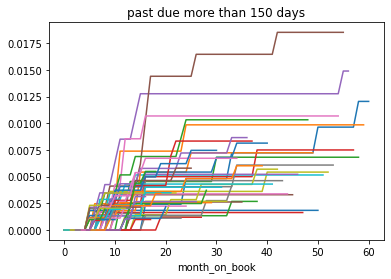

In [438]:
for i in [30,60,90,120,150]:
    vintage_values = "def{}_ratio_cum".format(i)
    vintage.pivot(index = "start_month", columns="month_on_book",values=vintage_values).T.plot(legend = False,title = "past due more than {} days".format(i))

In [19]:
mob = pd.DataFrame(index =set(vintage["month_on_book"]) )
for i  in [30,60,90,120,150]:
    imob = vintage.groupby("month_on_book")["def{}_num".format(i)].sum().cumsum() / len(set(credit["ID"]))
    mob = mob.merge(imob, right_index=True, left_index= True)
mob.columns= ["def30","def60","def90","def120","def150"]

## step 5： moving average
In order to compare the default probabilities, we use the movng average to smooth out the PD 

<AxesSubplot:>

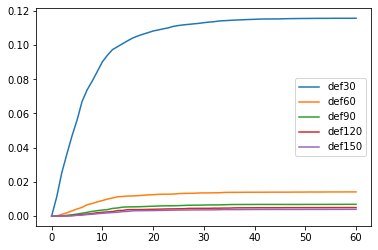

In [20]:
mob.plot()

## Step 6: Select past due days

In [21]:
summary_dt = pd.DataFrame({'situation':[
                                'past due more than 30 days',
                               'past due more than 60 days',
                               'past due more than 90 days',
                               'past due more than 120 days',
                               'past due more than 150 days'],
                      'Default rate':[
                               round(float(mob["def30"].tail(1).values),4),
                               round(float(mob["def60"].tail(1).values),4),
                               round(float(mob["def90"].tail(1).values),4), 
                              round(float(mob["def120"].tail(1).values),4),
                               round(float(mob["def150"].tail(1).values),4), 
                      ]})
summary_dt                    

,situation,Default rate
0,past due more than 30 days,0.1157
1,past due more than 60 days,0.0141
2,past due more than 90 days,0.0068
3,past due more than 120 days,0.0049
4,past due more than 150 days,0.0039


Select 60 days as the default days 

## Step 7: Determine window

<AxesSubplot:>

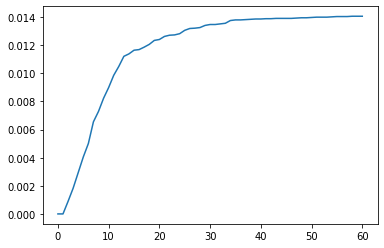

In [444]:
mob["def60"].plot()

The most default climents concentrated on the first year.   
And after 30 months, the behavior of customer become stable

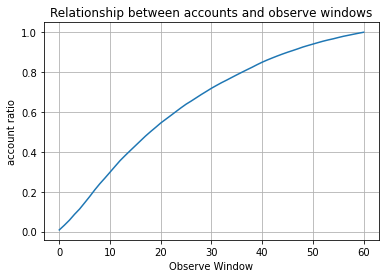

In [25]:
# change of applier's number with the increase of window
window = credit.groupby(["ID","window"])["window"].count().groupby("window").count().cumsum() / len(set(credit["ID"]))
window.plot(legend = False, grid = True, title = "Relationship between accounts and observe windows")
plt.xlabel('Observe Window')
plt.ylabel('account ratio')
plt.show()

In [26]:
print("The number of accounts with over 30 monthes window is {}".format(len(set(credit[credit["window"] > 35]["ID"]))))

print("The number of accounts with over 13 monthes window is {}".format(len(set(credit[credit["window"] > 13]["ID"]))))

# 4. Merge tables

In [30]:
loans  = pd.read_csv("./data/application_record.csv")
loans.sample(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
227674,5987295,F,N,N,0,225000.0,Commercial associate,Higher education,Civil marriage,With parents,-14668,-3729,1,0,0,0,Sales staff,2.0
422131,7066454,F,N,Y,0,315000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-20092,-1345,1,0,0,0,Cleaning staff,1.0
324948,6291700,F,Y,Y,0,810000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-16500,-3031,1,0,1,0,NaN,2.0
14769,5041924,M,N,N,0,135000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-22765,365243,1,0,1,0,NaN,2.0
383659,6689849,F,N,N,0,103500.0,Working,Secondary / secondary special,Separated,House / apartment,-18484,-3533,1,0,0,0,NaN,1.0


In [31]:
def_status = credit.groupby("ID").agg({"def60_dedup":["sum"]}).reset_index()
def_status.columns = ["ID","status"]
def_status = credit[["ID","window"]].drop_duplicates().merge(def_status, on = "ID")

# window over 13
def_status = def_status[(def_status["window"] > 13) | (def_status["status"] ==1)] 
def_status.drop(columns="window",inplace=True)

In [32]:
loans = loans.merge(def_status, on="ID")

In [33]:
loans.columns = ('ID','gender','car','realty','children_count','income_amount','income_type','education_type','family_status','housing_type',
                    'days_birth','days_employed','mobile','work_phone','phone','email','occupation_type','family_members','status')

In [34]:
loans.info()

In [454]:
loans.head()

,ID,gender,car,realty,children_count,income_amount,income_type,education_type,family_status,housing_type,days_birth,days_employed,mobile,work_phone,phone,email,occupation_type,family_members,status
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0.0
3,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0.0
4,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0.0


In [35]:
# switch days of birth and employment to years. 
loans.loc[:,"age"] =  -loans.loc[:,"days_birth"]//365
loans.loc[:,"working_yr"] =  -loans.loc[:,"days_employed"]//365

loans.drop(columns=["days_birth","days_employed"],inplace=True)

In [37]:
loans.to_csv("./Data/Credit_Card.csv")